In [99]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import read_qdp
import os
import sys

import pickle
import time

from sklearn.manifold import TSNE
from IPython.display import clear_output

In [95]:
class container(object):
    def __init__(self, dirname):
        
        # dictionaries with filename as key, data is 2d nparray holding original IV values
        self.data = self.create_training_data(dirname)
        self.dirname = dirname.split('\\')[-1]
        
        # dataframe holding extracted features with name as id
        # convert function to extract features into method and save as dataframe
        self.features = self.extract_features()
        
        
    def create_labels(self):
        rows_list = []
        data_dict = {}
        for name, data in self.data.items():
            print(name)
            plt.scatter(data[0], data[1])
            plt.show()
            for n in range(5):
                
                if input('Same?') == '1':
                    #clear_output()
                    print(data_dict)
                    data_repeat = data_dict.copy()
                    data_repeat['name'] = name
                    print(data_dict)
                    rows_list.append(data_repeat)
                    print(rows_list)
                    break
                data_dict = {}
                data_dict['name'] = name
                print('-----')  
                data_dict['double'] = input('Double Sided? 1/0')
                print('-----')
                data_dict['noise'] = input('Noise? 1/0')
                print('-----')
                data_dict['sup_con'] = input('Super? 1/0')
                print('-----')
                data_dict['trans'] = input('Trans? 2/1/0')
                print('-----')
                data_dict['ohmic'] = input('Ohmic? 2/1/0')

                if 'e' not in data_dict.values():
                    #clear_output()
                    print('next')
                    rows_list.append(data_dict)
                    print(rows_list)
                    break

            df =  pd.DataFrame(rows_list) 
            df.replace([np.inf, -np.inf], np.nan)
            df = df.dropna()
            df = df.reset_index()
            self.labels = df
        
    
    def create_training_data(self, dirname):
        series = {}
        for filename in os.listdir(dirname):
            if filename.endswith(".qdp"):
                print(filename)
                qdp = read_qdp.read_qdp(dirname+ '\\' +filename)
                new1 = qdp.iloc[:,0]
                new2 = qdp.iloc[:,1]

                series[filename] = np.array([new1,new2])
            elif filename.endswith(".xls") or  filename.endswith(".xlxs"):
                dataDict = pd.read_excel(dirname + '\\' + filename, sheet_name=None)
                for name, sheet in dataDict.items():
                    new1 = sheet.iloc[:,0]
                    new2 = sheet.iloc[:,1]
                    series[filename] = np.array([new1,new2])

        return series

    def extract_features(self):
        rows_list = []
        for name, data in self.data.items():
            rawI, rawV = data #Store as individual np.arrays for more readable code
            try:
                raw_grad = np.gradient(rawV, rawI)
                data_dict = {}


                turns = 0
                for i in range(len(raw_grad)-1):
                    if raw_grad[i] * raw_grad[i+1] < 0:
                        turns += 1
                
                data_dict['name'] = name
                data_dict['double_sided'] = 0.8*abs(np.min(rawI)) < np.max(rawI) < 1.2*abs(np.min(rawI))       
                #data_dict['V_range'] = (np.max(rawV) * np.min(rawV)) > 0 
                #data_dict['I_range'] = (np.max(rawI) * np.min(rawI)) < 0 
                data_dict['super'] = np.max(raw_grad) > 2*np.sum(raw_grad[:10])/10
                data_dict['trans'] = np.min(raw_grad) < 0       
                data_dict['turns'] = turns
                data_dict['noise'] = np.std(raw_grad)


                rows_list.append(data_dict)
            except:
                pass
            i += 1
        df =  pd.DataFrame(rows_list)#, index='filename') 
        df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        df = df.reset_index()
        return self.clean_dataset(df)
    
    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
        return df[indices_to_keep]#.astype(np.float64)
    
    def save(self):
        timestr = time.strftime("%Y%m%d-%H%M%S")
        filename = self.dirname + timestr
        with open(filename, 'wb') as fh:
               pickle.dump(self, fh)


In [96]:
test = container(r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\test_data')

IVTES2gain10HBB_60.35mK_BB125.00K_magnet0uA.qdp
IVTES2gain10HBB_60.35mK_BB130.00K_magnet0uA.qdp


IVTES2gain10HBB_60.35mK_BB125.00K_magnet0uA.qdp


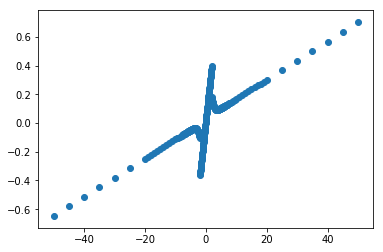

Same?q
-----
Double Sided? 1/01
-----
Noise? 1/01
-----
Super? 1/01
-----
Trans? 2/1/01
-----
Ohmic? 2/1/01
next
[{'name': 'IVTES2gain10HBB_60.35mK_BB125.00K_magnet0uA.qdp', 'double': '1', 'noise': '1', 'sup_con': '1', 'trans': '1', 'ohmic': '1'}]
IVTES2gain10HBB_60.35mK_BB130.00K_magnet0uA.qdp


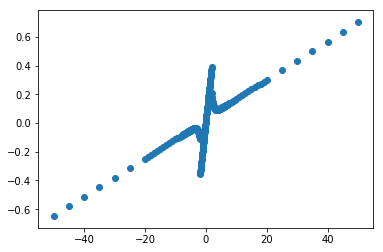

Same?
-----
Double Sided? 1/01
-----
Noise? 1/01
-----
Super? 1/01
-----
Trans? 2/1/01
-----
Ohmic? 2/1/01
next
[{'name': 'IVTES2gain10HBB_60.35mK_BB125.00K_magnet0uA.qdp', 'double': '1', 'noise': '1', 'sup_con': '1', 'trans': '1', 'ohmic': '1'}, {'name': 'IVTES2gain10HBB_60.35mK_BB130.00K_magnet0uA.qdp', 'double': '1', 'noise': '1', 'sup_con': '1', 'trans': '1', 'ohmic': '1'}]


In [97]:
test.create_labels()

In [100]:
test.save()

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def extract_features(data_set):
    rows_list = []
    for data in data_set:
        data_dict = {}
        rawI = (data[0].iloc[:,0].dropna()).values #Store as individual np.arrays for more readable code
        rawV = (data[0].iloc[:,1].dropna()).values
        try:
            raw_grad = np.gradient(rawV, rawI)



            turns = 0
            for i in range(len(raw_grad)-1):
                if raw_grad[i] * raw_grad[i+1] < 0:
                    turns += 1

            data_dict['double_sided'] = 0.8*abs(np.min(rawI)) < np.max(rawI) < 1.2*abs(np.min(rawI))       
            #data_dict['V_range'] = (np.max(rawV) * np.min(rawV)) > 0 
            #data_dict['I_range'] = (np.max(rawI) * np.min(rawI)) < 0 
            data_dict['super'] = np.max(raw_grad) > 2*np.sum(raw_grad[:10])/10
            data_dict['trans'] = np.min(raw_grad) < 0       
            data_dict['turns'] = turns
            data_dict['noise'] = np.std(raw_grad)
            

            rows_list.append(data_dict)
        except:
            pass
        i += 1
    df =  pd.DataFrame(rows_list) 
    df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    df = df.reset_index()
    return clean_dataset(df)

        

In [3]:
def create_training_data(dirname):
    series = []
    for filename in os.listdir(dirname):
        if filename.endswith(".qdp"):
            print(filename)
            qdp = read_qdp.read_qdp(dirname+ '\\' +filename)
            new1 = qdp.iloc[:,0]
            new2 = qdp.iloc[:,1]
            series.append([pd.concat([new1,new2], axis=1), pd.DataFrame(data={'name': [filename]})])
        elif filename.endswith(".xls") or  filename.endswith(".xlxs"):
            dataDict = pd.read_excel(dirname + '\\' + filename, sheet_name=None)
            for name, sheet in dataDict.items():
                new1 = sheet.iloc[:,0]
                new2 = sheet.iloc[:,1]
                series.append([pd.concat([new1,new2], axis=1), name])
            
    return series



def create_labeled_data(series):
    for entry in series:
        plt.scatter(entry[0].iloc[:,0], entry[0].iloc[:,1])
        plt.show()
        
        while(True):
        
            if input('Same?') == '1':
                clear_output()
                entry.append(labels)
                break
            print('-----')  
            double = input('Double Sided? 1/0')
            print('-----')
            noise = input('Noise? 1/0')
            print('-----')
            sup_con = input('Super? 1/0')
            print('-----')
            trans = input('Trans? 2/1/0')
            print('-----')
            ohmic = input('Ohmic? 2/1/0')
            
            labels = [double, noise, sup_con, trans, ohmic]
            if 'e' not in labels:
                clear_output()
                entry[1][]
                break

            
    
    return series
       
    
def training_subset(dirname, filename):
    
    data = create_training_data(dirname)
    # list of [dataframe, name] entries
    print(data)
    labeled = create_labeled_data(data)
    # appends [label] to entries in data list 
    print(labeled)
    features = extract_features(data)
    # creates a dataframe from the raw data
    print(features)
    features['targets'] = labeled[2,:]
    print(features)
    
    return features
    
    

In [4]:
test = training_subset(r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\test_data', 'hello')

[[         bias  V fb (V)
1  -50.000859 -0.646671
3  -45.008061 -0.580356
5  -39.997043 -0.513561
7  -35.004245 -0.447003
9  -29.993226 -0.380248
11 -25.000429 -0.313739
13 -20.007632 -0.247206
15 -19.005428 -0.233836
17 -18.003225 -0.220477
19 -17.001021 -0.207107
21 -15.998817 -0.193838
23 -14.996613 -0.180456
25 -13.994409 -0.167131
27 -12.992206 -0.153838
29 -12.008224 -0.140747
31 -11.006020 -0.127486
33 -10.003816 -0.114186
35  -9.493603 -0.107474
37  -9.001612 -0.100993
39  -8.491399 -0.094225
41  -7.999409 -0.087747
43  -7.798968 -0.085173
45  -7.598527 -0.082511
47  -7.398086 -0.079897
49  -7.197645 -0.077305
51  -6.997205 -0.074694
53  -6.906095 -0.073497
55  -6.796764 -0.072059
57  -6.705655 -0.070923
59  -6.596323 -0.069497
..        ...       ...
58   6.596323  0.123467
56   6.705655  0.124824
54   6.796764  0.126031
52   6.906095  0.127445
50   6.997205  0.128637
48   7.197645  0.131246
46   7.398086  0.133852
44   7.598527  0.136468
42   7.798968  0.139112
40   7.999409 

TypeError: list indices must be integers or slices, not tuple

In [10]:
test.head()

StopIteration: 

StopIteration: 

# data

In [2]:
data = create_training_data(r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\test_data')

NameError: name 'create_training_data' is not defined

In [5]:
df = extract_features(data)

C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1003: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1003: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1004: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1005: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\callu\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1011: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + 

In [6]:
df.drop(['index'], axis=1)

,double_sided,noise,super,trans,turns
0,1.0,0.036668,0.0,1.0,2.0
1,1.0,0.036710,0.0,1.0,2.0
2,1.0,0.035531,0.0,1.0,2.0
3,1.0,0.036293,0.0,1.0,2.0
4,1.0,0.036376,0.0,1.0,2.0
5,1.0,0.035654,0.0,1.0,2.0
6,1.0,0.035349,0.0,1.0,2.0
7,1.0,0.035278,0.0,1.0,2.0
8,1.0,0.035136,0.0,1.0,2.0
9,1.0,0.035129,0.0,1.0,2.0


In [7]:
df

,index,double_sided,noise,super,trans,turns
0,0.0,1.0,0.036668,0.0,1.0,2.0
1,1.0,1.0,0.036710,0.0,1.0,2.0
2,2.0,1.0,0.035531,0.0,1.0,2.0
3,3.0,1.0,0.036293,0.0,1.0,2.0
4,4.0,1.0,0.036376,0.0,1.0,2.0
5,5.0,1.0,0.035654,0.0,1.0,2.0
6,6.0,1.0,0.035349,0.0,1.0,2.0
7,7.0,1.0,0.035278,0.0,1.0,2.0
8,8.0,1.0,0.035136,0.0,1.0,2.0
9,9.0,1.0,0.035129,0.0,1.0,2.0


In [8]:
model = KMeans(n_clusters=10)

model.fit(df.drop("index",axis=1).values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
all_predictions = model.predict(df.drop("index",axis=1).values)
print(all_predictions)
print(len(all_predictions))

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 4 7 7 0 0 4 0 0 9 0 0 0 0 9 7
 4 0 0 0 0 5 5 5 5 5 5 5 5 0 5 0 5 0 0 9 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 9 0 0 8 4 8 8 6 8 4 8 4 8 9 8 8
 8 8 8 8 4 4 4 4 4 3 0 0 9 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 9 9 0 0 8 4 8 8 6 8 4 8 4 8 9 8 8 8 8 0 0 0 7 0
 7 7 0 7 7 7 7 7 7 7 0 7 0 7 7 7 7 7 7 0 7 7 0 7 7 7 7 0 0 0 0 7 7 7 7 0 0
 7 0 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 1 8 4 0 0 0 9 7 8 6 6 6 2 8 8 8 8 8
 4 8 4 4 4 4 4 4 4 4 4 4 4 4 7 1 1 7 7 7 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 9 0 0 9 0
 0 0 7 0 0 9 0 0 9 7 0 0 

In [215]:
print(all_predictions[30])

8


23.0


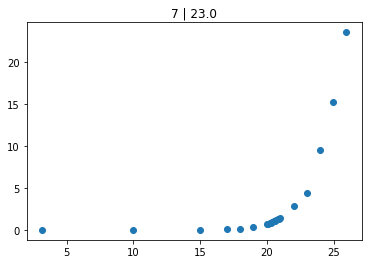

24.0


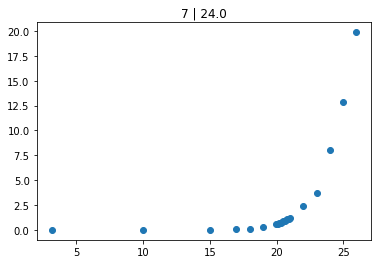

36.0


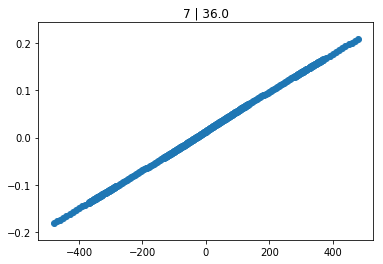

186.0


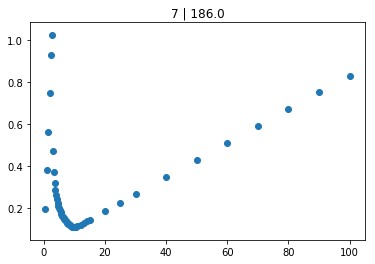

188.0


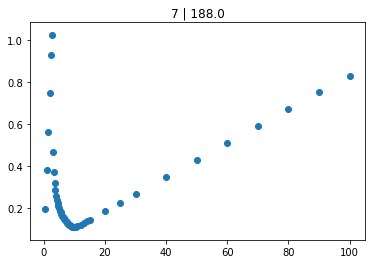

189.0


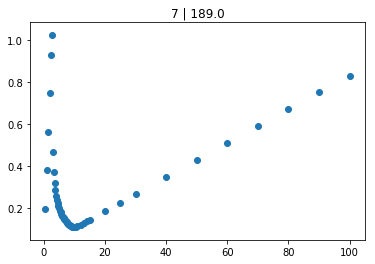

191.0


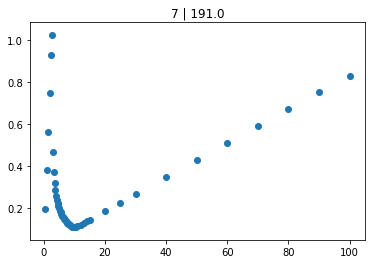

192.0


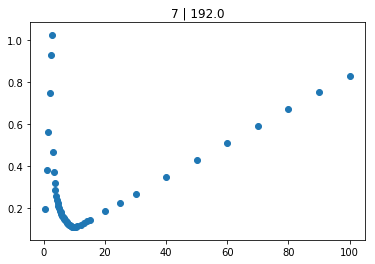

193.0


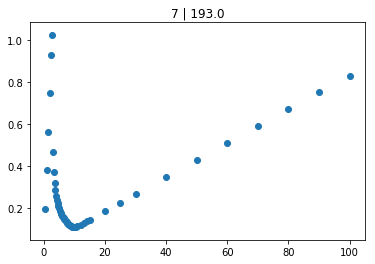

194.0


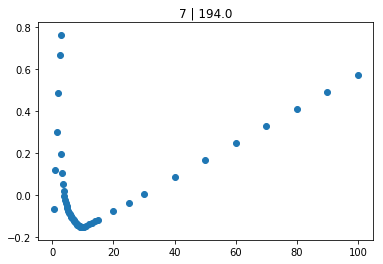

195.0


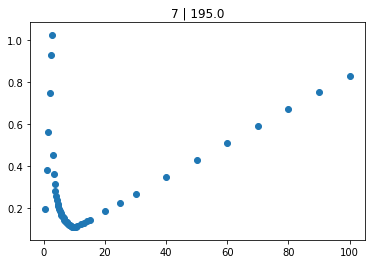

196.0


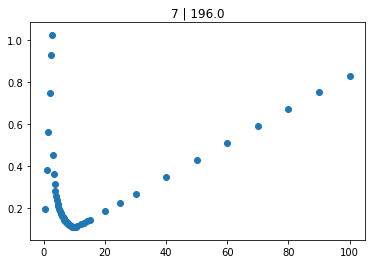

197.0


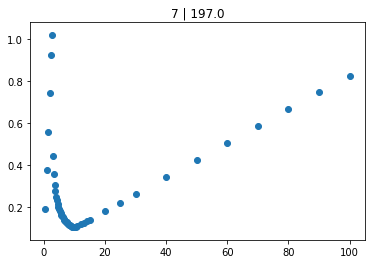

199.0


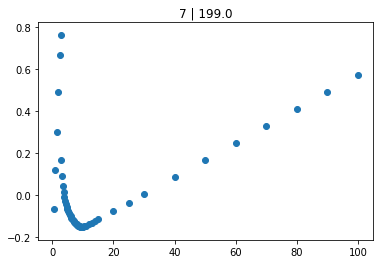

201.0


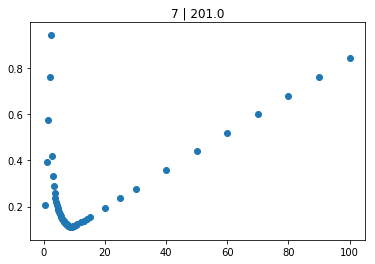

202.0


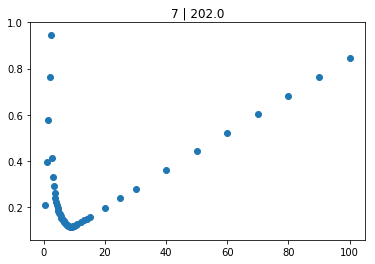

203.0


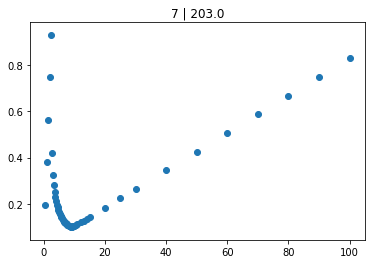

204.0


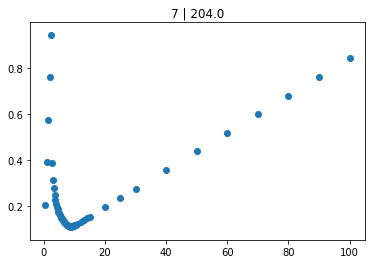

205.0


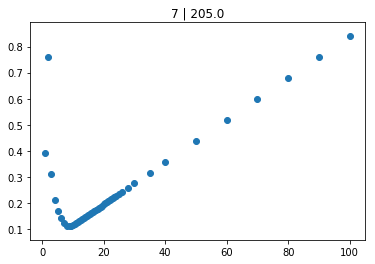

206.0


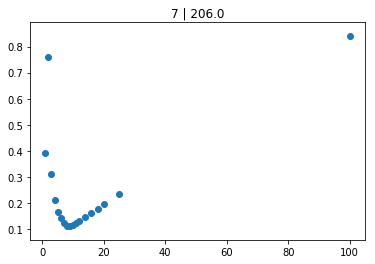

208.0


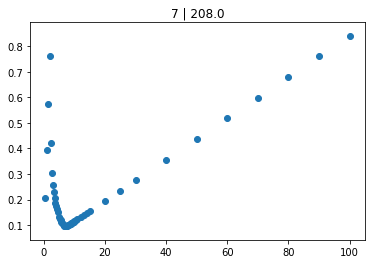

209.0


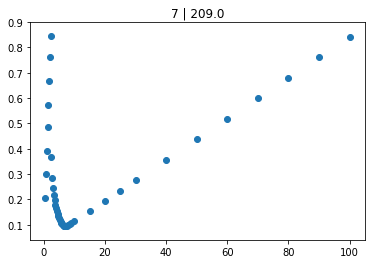

211.0


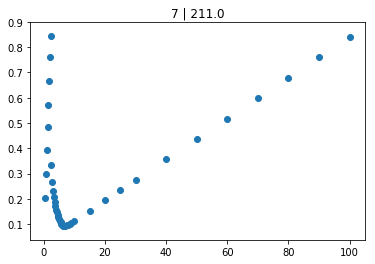

212.0


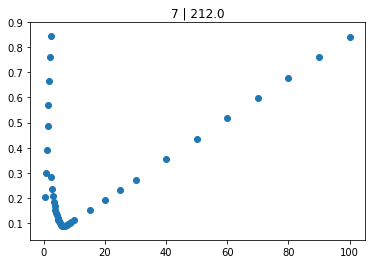

213.0


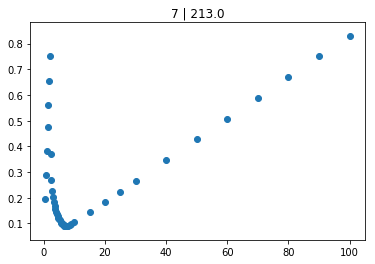

214.0


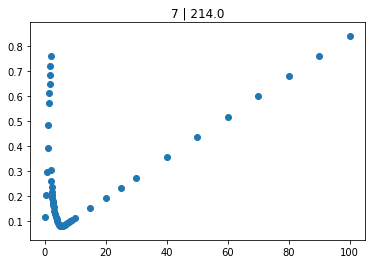

219.0


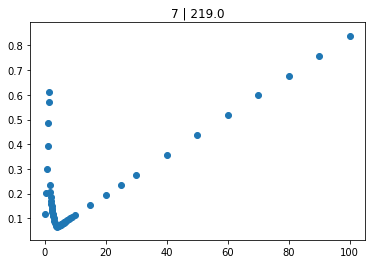

220.0


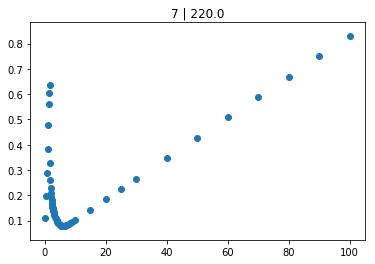

221.0


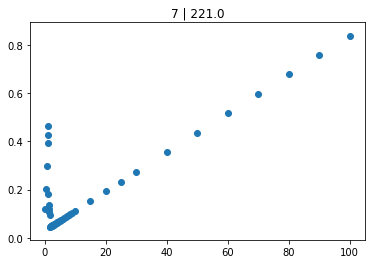

222.0


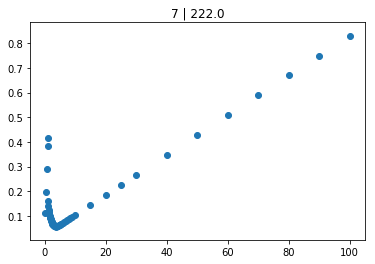

225.0


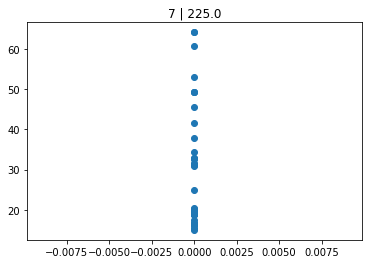

227.0


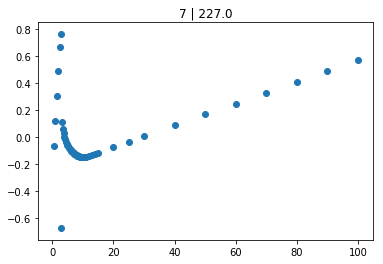

228.0


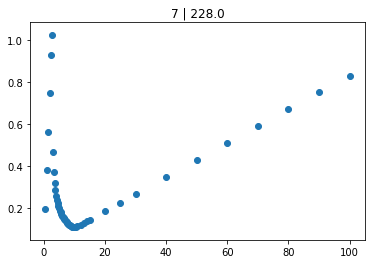

230.0


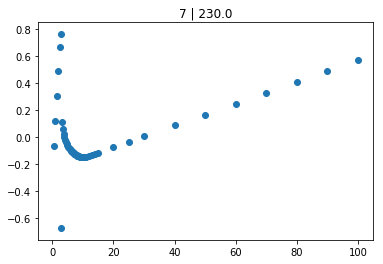

231.0


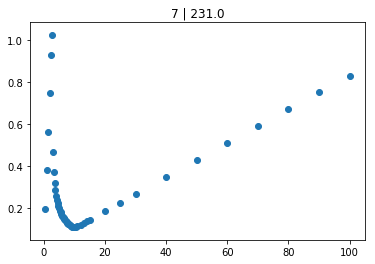

232.0


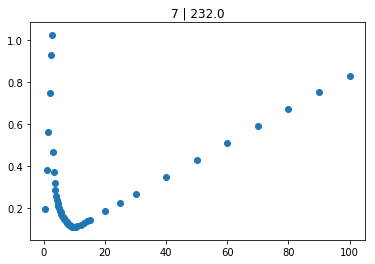

233.0


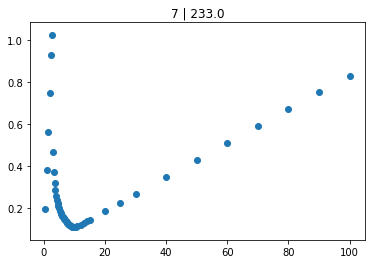

234.0


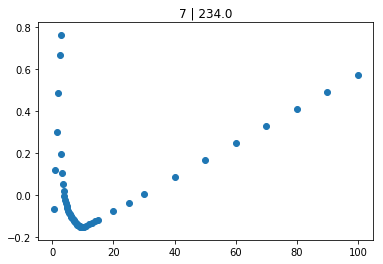

235.0


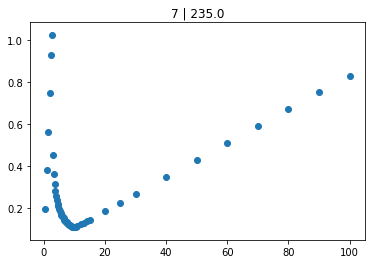

236.0


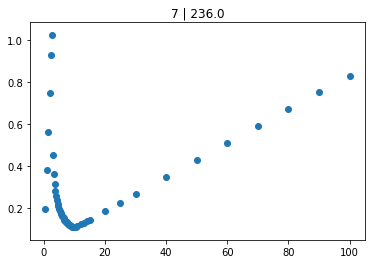

237.0


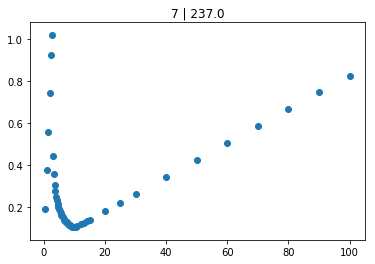

238.0


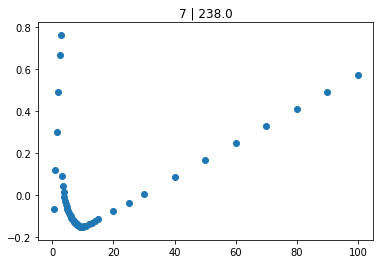

239.0


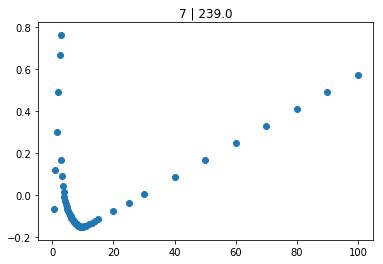

240.0


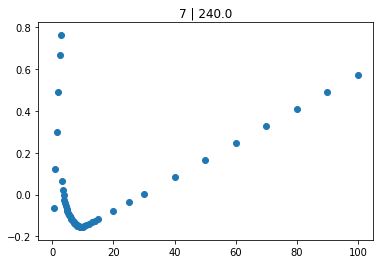

241.0


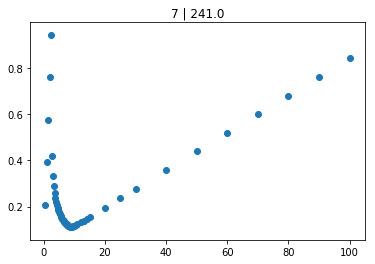

242.0


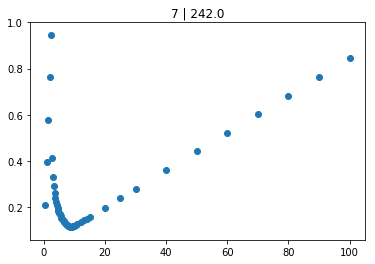

243.0


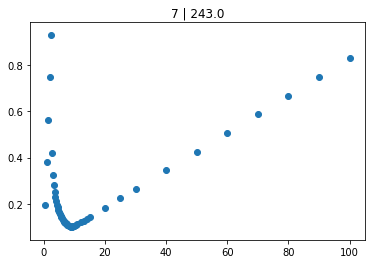

244.0


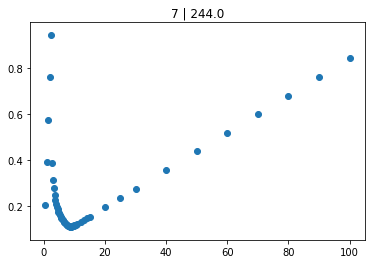

245.0


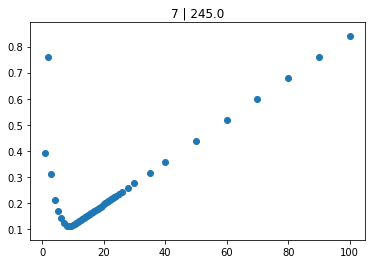

246.0


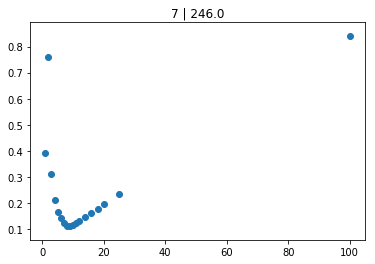

247.0


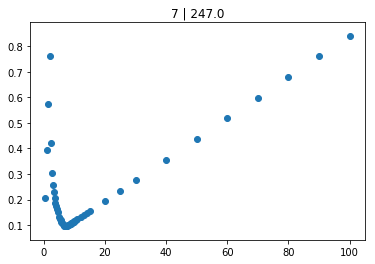

249.0


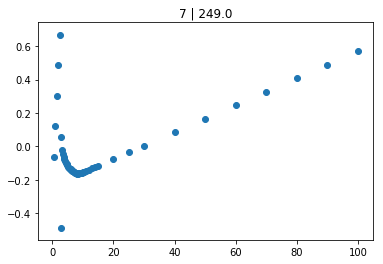

250.0


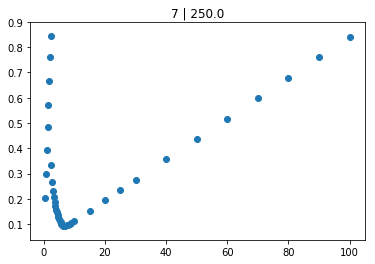

251.0


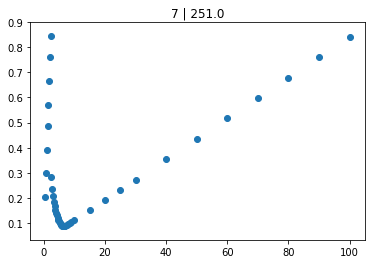

252.0


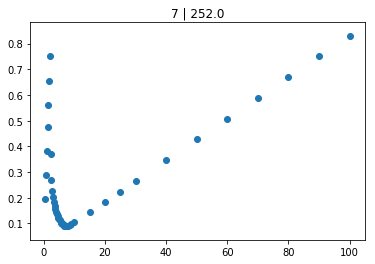

253.0


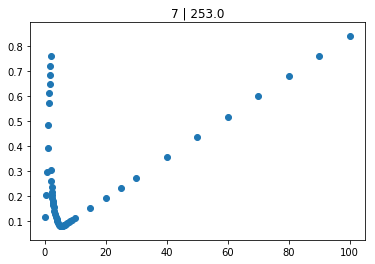

254.0


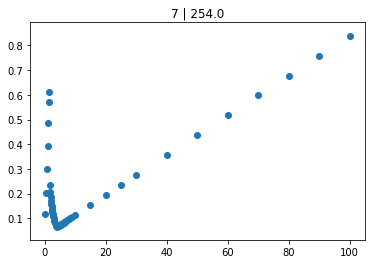

255.0


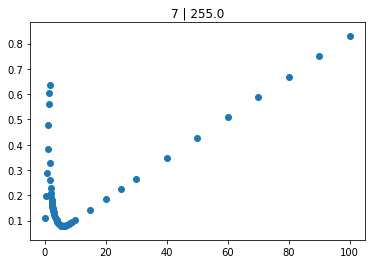

256.0


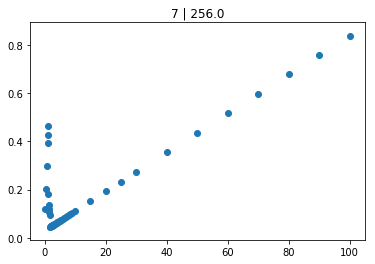

257.0


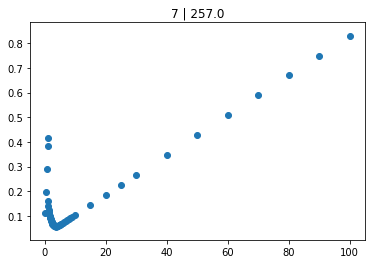

258.0


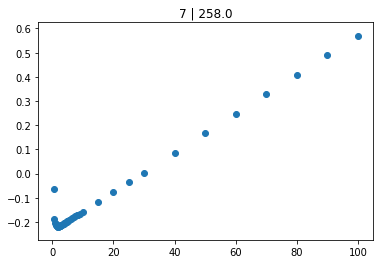

404.0


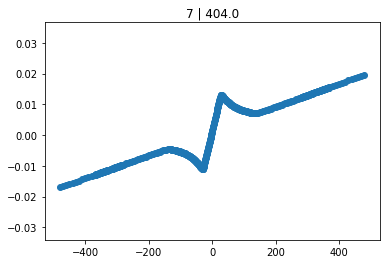

429.0


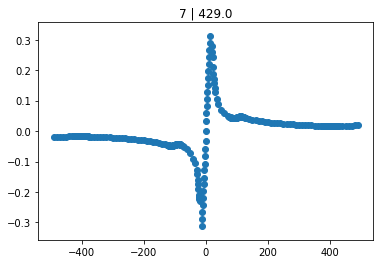

432.0


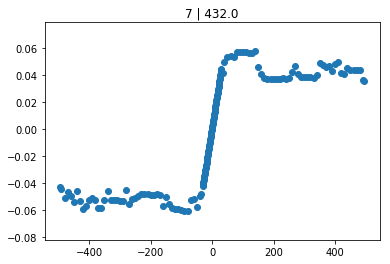

433.0


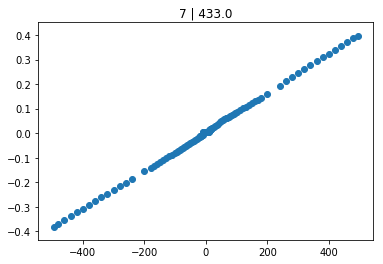

434.0


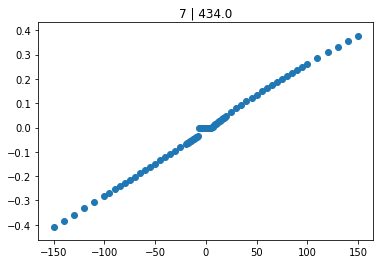

461.0


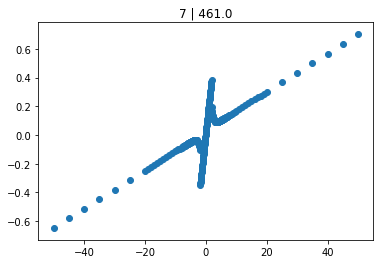

477.0


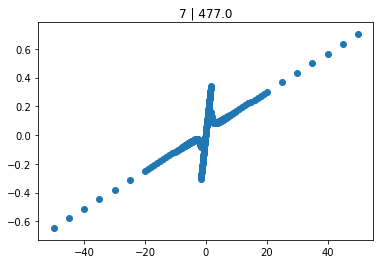

491.0


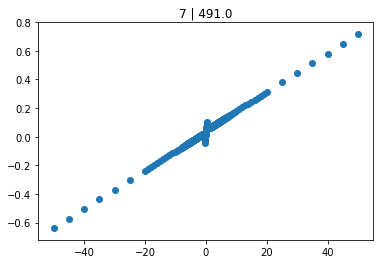

498.0


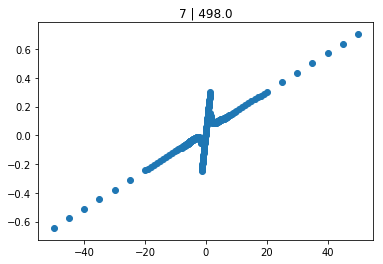

502.0


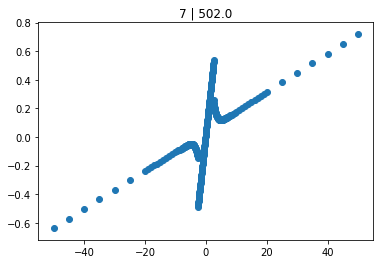

509.0


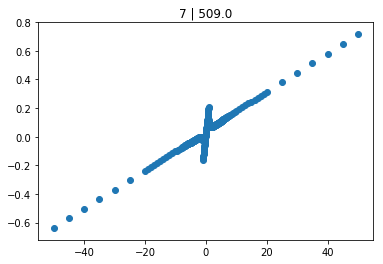

510.0


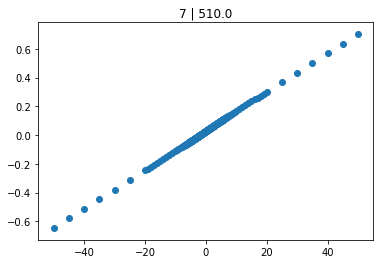

514.0


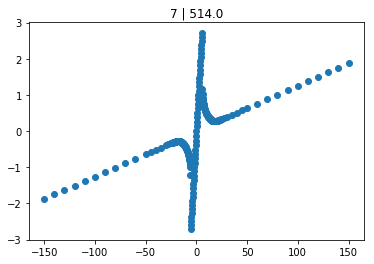

In [12]:
for index, row in df.iterrows():
    if all_predictions[index] == 7:
        print((row['index']))
        plt.scatter(data[int(row['index'])][0].iloc[:,0], data[int(row['index'])][0].iloc[:,1])

        plt.title(str(all_predictions[index]) + ' | ' + str(row['index']))
        plt.show()

In [251]:
df.loc[df['index'] == 506]

,index,double_sided,noise,super,trans,turns
498,506.0,1.0,0.424703,1.0,1.0,6.0


In [252]:
model2 = TSNE(learning_rate=100)
transformed = model2.fit_transform(df.drop("index",axis=1).values)

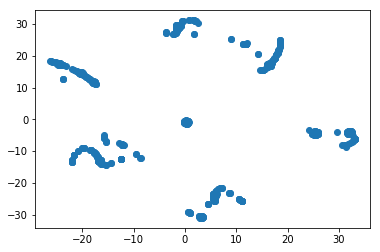

In [253]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)#, c=iris_df.target)
plt.show()

In [260]:
pca = PCA(n_components=6).fit(df.values)
pca_2d = pca.transform(df.values)

In [276]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics

In [337]:
db = DBSCAN(eps=1, min_samples=3)
db.fit(df.drop("index",axis=1).values)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)

In [338]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [339]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 11
Estimated number of noise points: 27


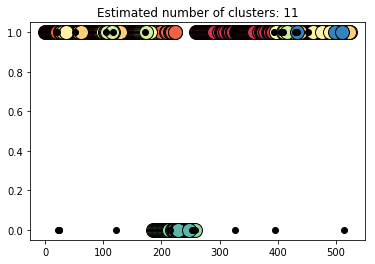

In [340]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df.values[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df.values[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [343]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dbscan = DBSCAN(eps=0.123, min_samples = 2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

NameError: name 'X' is not defined